# Extraction And Attribution Of Public Figures Statements For Journalism In Indonesia Using Deep Learning

## Objectives
To develop a single pipeline model for the extraction and attribution of public figures statement in Indonesian news articles using deep learning algorithms

## EXP at Tesla P4 - Weight and Bias with More Data 70-30 V2

## Importing Python Library

In [53]:
import math
import time
import gensim
import torch
import torchcrf
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchtext.data import Field, NestedField, BucketIterator
from torchtext.datasets import SequenceTaggingDataset
from torchtext.vocab import Vocab
from collections import Counter
from spacy.lang.id import Indonesian
from sklearn.metrics import f1_score, classification_report, precision_recall_fscore_support
from torch_lr_finder import LRFinder

## Checking GPU Availability

In [54]:
available_gpu = torch.cuda.is_available()
if available_gpu:
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    use_device = torch.device("cuda")
else:
    use_device = torch.device("cpu")

GPU is available: NVIDIA GeForce RTX 3050 Laptop GPU


In [55]:
use_device

device(type='cuda')

## Weight and Bias Integration to Track the Experiments

In [56]:
import wandb
import os
import os
from dotenv import load_dotenv
load_dotenv()

wandb_api_key = os.getenv("WANDB_API_KEY", "")
wandb.login(key = wandb_api_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: WARNING Calling wandb.login() without arguments from jupyter should prompt you for an api key.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\RAYMOND/.netrc


True

In [57]:
wandb.init(project="pfsa-id-teslap4-7030-v2",entity="r76127011-wkdl")

wandb: Wandb version 0.19.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/r76127011-wkdl/pfsa-id-teslap4-7030-v2/runs/5c86n0au

In [58]:
columns_metrics_train=["model","epoch","train_loss","train_p","train_r","train_f1","val_loss","val_p","val_r","val_f1"]
data_table_metrics_train = wandb.Table(columns=columns_metrics_train)

In [59]:
columns_metrics_test=["model","test_loss","test_p","test_r","test_f1","best_epoch","best_val_f1","ellapse_train_times"]
data_table_metrics_test = wandb.Table(columns=columns_metrics_test)

### Setting Random Seed

In [60]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
if available_gpu:
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.enabled = False 

## Corpus Loader

Setting the path location of corpus and class declaration that used for loading the corpus and converting the field into vocabulary list.

In [61]:
import sys
DRIVE_ROOT = "corpus-raymond"
if DRIVE_ROOT not in sys.path:
    sys.path.append(DRIVE_ROOT)


In [72]:
import gensim.downloader as api

class Corpus(object):

    def __init__(self, input_folder, min_word_freq, batch_size, wv_file=None):
        # list all the fields
        self.word_field = Field(lower=True)  # [sent len, batch_size]
        self.tag_field = Field(
            
            unk_token=None)  # [sent len, batch_size]
        # Character-level input
        self.char_nesting_field = Field(tokenize=list)
        self.char_field = NestedField(self.char_nesting_field)  # [batch_size, sent len, max len char]
        # create dataset using built-in parser from torchtext
        self.train_dataset, self.val_dataset, self.test_dataset = SequenceTaggingDataset.splits(
            path=input_folder,
            train="train-full.txt",
            validation="validation-full.txt",
            test="validation-full.txt",
            fields=(
                (("word", "char"), (self.word_field, self.char_field)),
                ("tag", self.tag_field)
            )
        )
        # convert fields to vocabulary list
        if wv_file:
            self.wv_model = gensim.models.word2vec.Word2Vec.load(wv_file)
            self.embedding_dim = self.wv_model.vector_size
            word_freq = {word: self.wv_model.wv.vocab[word].count for word in self.wv_model.wv.vocab}
            word_counter = Counter(word_freq)
            self.word_field.vocab = Vocab(word_counter, min_freq=min_word_freq)
            vectors = []
            for word, idx in self.word_field.vocab.stoi.items():
                if word in self.wv_model.wv.vocab.keys():
                    vectors.append(torch.as_tensor(self.wv_model.wv[word].tolist()))
                else:
                    vectors.append(torch.zeros(self.embedding_dim))
            self.word_field.vocab.set_vectors(
                stoi=self.word_field.vocab.stoi,
                vectors=vectors,
                dim=self.embedding_dim
            )
        else:
            self.wv_model = api.load("word2vec-google-news-300")
            self.embedding_dim = self.wv_model.vector_size
            word_freq = {word: self.wv_model.wv.vocab[word].count for word in self.wv_model.wv.vocab}
            word_counter = Counter(word_freq)
            self.word_field.vocab = Vocab(word_counter, min_freq=min_word_freq)
            vectors = []
            for word, idx in self.word_field.vocab.stoi.items():
                if word in self.wv_model.wv.vocab.keys():
                    vectors.append(torch.as_tensor(self.wv_model.wv[word].tolist()))
                else:
                    vectors.append(torch.zeros(self.embedding_dim))
            self.word_field.vocab.set_vectors(
                stoi=self.word_field.vocab.stoi,
                vectors=vectors,
                dim=self.embedding_dim
            )

        # build vocab for tag and characters
        self.char_field.build_vocab(self.train_dataset.char)
        self.tag_field.build_vocab(self.train_dataset.tag)
        # create iterator for batch input
        self.train_iter, self.val_iter, self.test_iter = BucketIterator.splits(
            datasets=(self.train_dataset, self.val_dataset, self.test_dataset),
            batch_size=batch_size
        )
        # prepare padding index to be ignored during model training/evaluation
        self.word_pad_idx = self.word_field.vocab.stoi[self.word_field.pad_token]
        self.char_pad_idx = self.char_field.vocab.stoi[self.char_field.pad_token]
        self.tag_pad_idx = self.tag_field.vocab.stoi[self.tag_field.pad_token]

In [ ]:
corpus = Corpus(
    input_folder=f"{DRIVE_ROOT}",
    min_word_freq=3,
    batch_size=64
    # wv_file=f"{DRIVE_ROOT}/id.bin"
)
print(f"Train set: {len(corpus.train_dataset)} sentences")
print(f"Val set: {len(corpus.val_dataset)} sentences")
print(f"Test set: {len(corpus.test_dataset)} sentences")

[--------------------------------------------------] 1.4% 23.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==------------------------------------------------] 4.2% 69.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===-----------------------------------------------] 6.2% 103.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====----------------------------------------------] 8.9% 147.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====---------------------------------------------] 11.6% 192.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 14.4% 238.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========------------------------------------------] 16.9% 281.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========----------------------------------------] 20.8% 345.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========----------------------------------------] 21.9% 363.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========---------------------------------------] 22.9% 380.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============--------------------------------------] 24.9% 414.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============-------------------------------------] 27.4% 456.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============------------------------------------] 29.8% 495.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================----------------------------------] 32.3% 537.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 34.7% 576.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================--------------------------------] 36.9% 613.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================-------------------------------] 38.8% 644.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================------------------------------] 40.6% 675.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====================-----------------------------] 42.9% 713.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================----------------------------] 45.3% 752.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================---------------------------] 47.1% 782.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================--------------------------] 49.6% 825.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================-------------------------] 51.4% 854.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================------------------------] 53.8% 893.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================----------------------] 56.4% 937.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================----------------------] 57.7% 959.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================---------------------] 58.5% 973.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================--------------------] 60.5% 1006.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================-------------------] 62.6% 1041.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================------------------] 65.0% 1080.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================-----------------] 67.0% 1113.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================----------------] 69.3% 1152.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================================---------------] 71.3% 1185.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================================--------------] 73.7% 1224.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================================------------] 76.1% 1265.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================================------------] 78.0% 1297.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================================-----------] 78.7% 1308.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================================----------] 81.4% 1353.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================================---------] 83.8% 1393.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================================--------] 85.5% 1421.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========================================-------] 86.4% 1436.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================================------] 88.5% 1471.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================================-----] 90.7% 1508.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================================----] 92.9% 1544.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================================---] 95.1% 1582.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================================--] 97.7% 1624.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================================-] 99.8% 1659.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



X:\research\pfsa-id\.venv\lib\site-packages\ipykernel_launcher.py:46: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
X:\research\pfsa-id\.venv\lib\site-packages\ipykernel_launcher.py:51: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
X:\research\pfsa-id\.venv\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


## Model Components

### Embedding Layer

In [64]:
class Embeddings(nn.Module):

    def __init__(self,
                 word_input_dim,
                 word_emb_dim,
                 word_emb_pretrained,
                 word_emb_dropout,
                 word_emb_froze,
                 use_char_emb,
                 char_input_dim,
                 char_emb_dim,
                 char_emb_dropout,
                 char_cnn_filter_num,
                 char_cnn_kernel_size,
                 char_cnn_dropout,
                 word_pad_idx,
                 char_pad_idx,
                 device
                 ):
        super().__init__()
        self.device = device
        self.word_pad_idx = word_pad_idx
        self.char_pad_idx = char_pad_idx
        # Word Embedding
        # initialize embedding with pretrained weights if given
        if word_emb_pretrained is not None:
            self.word_emb = nn.Embedding.from_pretrained(
                embeddings=torch.as_tensor(word_emb_pretrained),
                padding_idx=self.word_pad_idx,
                freeze=word_emb_froze
            )
        else:
            self.word_emb = nn.Embedding(
                num_embeddings=word_input_dim,
                embedding_dim=word_emb_dim,
                padding_idx=self.word_pad_idx
            )
            self.word_emb.weight.data[self.word_pad_idx] = torch.zeros(word_emb_dim)
        self.word_emb_dropout = nn.Dropout(word_emb_dropout)
        self.output_dim = word_emb_dim
        # Char Embedding
        self.use_char_emb = use_char_emb
        if self.use_char_emb:
            self.char_emb_dim = char_emb_dim
            self.char_emb = nn.Embedding(
                num_embeddings=char_input_dim,
                embedding_dim=char_emb_dim,
                padding_idx=char_pad_idx
            )
            # initialize embedding for char padding as zero
            self.char_emb.weight.data[self.char_pad_idx] = torch.zeros(self.char_emb_dim)
            self.char_emb_dropout = nn.Dropout(char_emb_dropout)
            # Char CNN
            self.char_cnn = nn.Conv1d(
                in_channels=char_emb_dim,
                out_channels=char_emb_dim * char_cnn_filter_num,
                kernel_size=char_cnn_kernel_size,
                groups=char_emb_dim  # different 1d conv for each embedding dim
            )
            self.char_cnn_dropout = nn.Dropout(char_cnn_dropout)
            self.output_dim += char_emb_dim * char_cnn_filter_num

    def forward(self, words, chars):
        # words = [sentence length, batch size]
        # chars = [batch size, sentence length, word length)
        # tags = [sentence length, batch size]
        # embedding_out = [sentence length, batch size, embedding dim]
        embedding_out = self.word_emb_dropout(self.word_emb(words))
        if not self.use_char_emb: return embedding_out
        # character cnn layer forward
        # reference: https://github.com/achernodub/targer/blob/master/src/layers/layer_char_cnn.py
        # char_emb_out = [batch size, sentence length, word length, char emb dim]
        char_emb_out = self.char_emb_dropout(self.char_emb(chars))
        batch_size, sent_len, word_len, char_emb_dim = char_emb_out.shape
        char_cnn_max_out = torch.zeros(batch_size, sent_len, self.char_cnn.out_channels, device=self.device)
        for sent_i in range(sent_len):
            # sent_char_emb = [batch size, word length, char emb dim]
            sent_char_emb = char_emb_out[:, sent_i, :, :]
            # sent_char_emb_p = [batch size, char emb dim, word length]
            sent_char_emb_p = sent_char_emb.permute(0, 2, 1)
            # char_cnn_sent_out = [batch size, out channels * char emb dim, word length - kernel size + 1]
            char_cnn_sent_out = self.char_cnn(sent_char_emb_p)
            char_cnn_max_out[:, sent_i, :], _ = torch.max(char_cnn_sent_out, dim=2)
        char_cnn = self.char_cnn_dropout(char_cnn_max_out)
        # concat word and char embedding
        # char_cnn_p = [sentence length, batch size, char emb dim * num filter]
        char_cnn_p = char_cnn.permute(1, 0, 2)
        word_features = torch.cat((embedding_out, char_cnn_p), dim=2)
        return word_features


### LSTM Layer

In [65]:
class LSTMAttn(nn.Module):

    def __init__(self,
                 input_dim,
                 lstm_hidden_dim,
                 lstm_layers,
                 lstm_dropout,
                 word_pad_idx,
                 attn_heads=None,
                 attn_dropout=None
                 ):
        super().__init__()
        self.word_pad_idx = word_pad_idx
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_layers,
            bidirectional=True,
            dropout=lstm_dropout if lstm_layers > 1 else 0
        )
        self.attn_heads = attn_heads
        if self.attn_heads:
            self.attn = nn.MultiheadAttention(
                embed_dim=lstm_hidden_dim * 2,
                num_heads=attn_heads,
                dropout=attn_dropout
            )

    def forward(self, words, word_features):
        lstm_out, _ = self.lstm(word_features)
        if not self.attn_heads: return lstm_out
        # create masking for paddings
        key_padding_mask = torch.as_tensor(words == self.word_pad_idx).permute(1, 0)
        attn_out, _ = self.attn(lstm_out, lstm_out, lstm_out, key_padding_mask=key_padding_mask)
        return attn_out

### CRF Layer

In [66]:
class CRF(nn.Module):

    def __init__(self,
                 input_dim,
                 fc_dropout,
                 word_pad_idx,
                 tag_names,
                 ):
        super().__init__()
        self.word_pad_idx = word_pad_idx
        # Fully-connected
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(input_dim, len(tag_names))
        # CRF
        self.crf = torchcrf.CRF(num_tags=len(tag_names))
        self.init_crf_transitions(tag_names)

    def forward(self, words, word_features, tags):
        # fc_out = [sentence length, batch size, output dim]
        fc_out = self.fc(self.fc_dropout(word_features))
        crf_mask = words != self.word_pad_idx
        crf_out = self.crf.decode(fc_out, mask=crf_mask)
        crf_loss = -self.crf(fc_out, tags=tags, mask=crf_mask) if tags is not None else None
        return crf_out, crf_loss

    def init_crf_transitions(self, tag_names, imp_value=-100):
        num_tags = len(tag_names)
        for i in range(num_tags):
            tag_name = tag_names[i]
            # I and L and <pad> impossible as a start
            if tag_name[0] in ("I", "L") or tag_name == "<pad>":
                torch.nn.init.constant_(self.crf.start_transitions[i], imp_value)
            # B and I impossible as an end
            if tag_name[0] in ("B", "I"):
                torch.nn.init.constant_(self.crf.end_transitions[i], imp_value)
        # init impossible transitions between positions
        tag_is = {}
        for tag_position in ("B", "I", "O", "U", "L"):
            tag_is[tag_position] = [i for i, tag in enumerate(tag_names) if tag[0] == tag_position]
        tag_is["P"] = [i for i, tag in enumerate(tag_names) if tag == "tag"]
        impossible_transitions_position = {
            "B": "BOUP",
            "I": "BOUP",
            "O": "IL",
            "U": "IL"
        }
        for from_tag, to_tag_list in impossible_transitions_position.items():
            to_tags = list(to_tag_list)
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                        torch.nn.init.constant_(
                            self.crf.transitions[from_tag_i, to_tag_i], imp_value
                        )
        # init impossible B and I transitions to different entity types
        impossible_transitions_tags = {
            "B": "IL",
            "I": "IL"
        }
        for from_tag, to_tag_list in impossible_transitions_tags.items():
            to_tags = list(to_tag_list)
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                        if tag_names[from_tag_i].split("-")[1] != tag_names[to_tag_i].split("-")[1]:
                            torch.nn.init.constant_(
                                self.crf.transitions[from_tag_i, to_tag_i], imp_value
                            )



### Encoding Layer for Transformer

In [67]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=10000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)



### Transformer Layer

In [68]:
class Transformer(nn.Module):

    def __init__(self,
                 input_dim,
                 attn_heads,
                 attn_dropout,
                 trf_layers,
                 fc_hidden,
                 word_pad_idx
                 ):
        super().__init__()
        self.word_pad_idx = word_pad_idx
        self.position_encoder = PositionalEncoding(
            d_model=input_dim
        )
        layers = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=attn_heads,
            activation="relu",
            dropout=attn_dropout
        )
        self.trf = nn.TransformerEncoder(
            encoder_layer=layers,
            num_layers=trf_layers
        )
        # 2-layers fully-connected with GELU activation in-between
        self.fc = nn.Linear(
            in_features=input_dim,
            out_features=fc_hidden
        )
        self.fc_gelu = nn.GELU()
        self.fc_norm = nn.LayerNorm(fc_hidden)
        self.output_dim = fc_hidden

    def forward(self, words, word_features):
        # Transformer
        key_padding_mask = torch.as_tensor(words == self.word_pad_idx).permute(1, 0)
        # pos_out = [sentence length, batch size, embedding dim + char emb dim * num filter]
        pos_out = self.position_encoder(word_features)
        # enc_out = [sentence length, batch size, embedding dim + char emb dim * num filter]
        trf_out = self.trf(pos_out, src_key_padding_mask=key_padding_mask)
        # fc_out = [sentence length, batch size, fc hidden]
        fc_out = self.fc_norm(self.fc_gelu(self.fc(trf_out)))
        return fc_out


### Model Architecture for Public Figures Statements For Journalism In Indonesia using NER Approach

In [69]:
class NERModel(nn.Module):

    def __init__(self,
                 word_input_dim,
                 word_pad_idx,
                 char_pad_idx,
                 tag_names,
                 device,
                 name="",
                 model_arch="bilstm",
                 word_emb_dim=300,
                 word_emb_pretrained=None,
                 word_emb_dropout=0.5,
                 word_emb_froze=False,
                 use_char_emb=False,
                 char_input_dim=None,
                 char_emb_dim=None,
                 char_emb_dropout=None,
                 char_cnn_filter_num=None,
                 char_cnn_kernel_size=None,
                 char_cnn_dropout=None,
                 lstm_hidden_dim=64,
                 lstm_layers=2,
                 lstm_dropout=0.1,
                 attn_heads=None,
                 attn_dropout=None,
                 trf_layers=None,
                 fc_hidden=None,
                 fc_dropout=0.25
                 ):
        super().__init__()
        # Embeddings
        self.embeddings = Embeddings(
            word_input_dim=word_input_dim,
            word_emb_dim=word_emb_dim,
            word_emb_pretrained=word_emb_pretrained,
            word_emb_dropout=word_emb_dropout,
            word_emb_froze=word_emb_froze,
            use_char_emb=use_char_emb,
            char_input_dim=char_input_dim,
            char_emb_dim=char_emb_dim,
            char_emb_dropout=char_emb_dropout,
            char_cnn_filter_num=char_cnn_filter_num,
            char_cnn_kernel_size=char_cnn_kernel_size,
            char_cnn_dropout=char_cnn_dropout,
            word_pad_idx=word_pad_idx,
            char_pad_idx=char_pad_idx,
            device=device
        )
        if model_arch.lower() == "bilstm":
            # LSTM-Attention
            self.encoder = LSTMAttn(
                 input_dim=self.embeddings.output_dim,
                 lstm_hidden_dim=lstm_hidden_dim,
                 lstm_layers=lstm_layers,
                 lstm_dropout=lstm_dropout,
                 word_pad_idx=word_pad_idx,
                 attn_heads=attn_heads,
                 attn_dropout=attn_dropout
            )
            encoder_output_dim = lstm_hidden_dim * 2
        elif model_arch.lower() == "transformer":
            # Transformer
            self.encoder = Transformer(
                input_dim=self.embeddings.output_dim,
                attn_heads=attn_heads,
                attn_dropout=attn_dropout,
                trf_layers=trf_layers,
                fc_hidden=fc_hidden,
                word_pad_idx=word_pad_idx
            )
            encoder_output_dim = self.encoder.output_dim
        else:
            raise ValueError("param `model_arch` must be either 'bilstm' or 'transformer'")
        # CRF
        self.crf = CRF(
            input_dim=encoder_output_dim,
            fc_dropout=fc_dropout,
            word_pad_idx=word_pad_idx,
            tag_names=tag_names
        )

    def forward(self, words, chars, tags=None):
        word_features = self.embeddings(words, chars)
        # lstm_out = [sentence length, batch size, hidden dim * 2]
        encoder_out = self.encoder(words, word_features)
        # fc_out = [sentence length, batch size, output dim]
        crf_out, crf_loss = self.crf(words, encoder_out, tags)
        
        return crf_out, crf_loss

    def save_state(self, path):
        torch.save(self.state_dict(), path)

    def load_state(self, path):
        self.load_state_dict(torch.load(path))

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

### Model Training

The training sequence (`train()`) using the LR reduction and early stopping. For reducing LR, the pytorch built-in implementation `ReduceLROnPlateau` is used, while the early stopping is simply executed with a counter based on the F1 score. 

Note that the new score has to be at least 1% relatively better than the previous best score to be considered as a significant improvement.

In [70]:
class Trainer(object):

    def __init__(self, model, data, optimizer, device, checkpoint_path=None, model_name=None):
        self.device = device
        self.model = model.to(self.device)
        self.data = data
        self.optimizer = optimizer
        self.checkpoint_path = checkpoint_path
        self.model_name = model_name

    @staticmethod
    def epoch_time(start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    def f1_positive(self, preds, y, full_report=False):
        index_o = self.data.tag_field.vocab.stoi["O"]
        # take all labels except padding and "O"
        positive_labels = [i for i in range(len(self.data.tag_field.vocab.itos))
                           if i not in (self.data.tag_pad_idx, index_o)]
        # make the prediction one dimensional to follow sklearn f1 score input param
        flatten_preds = [pred for sent_pred in preds for pred in sent_pred]
        # remove prediction for padding and "O"
        positive_preds = [pred for pred in flatten_preds
                          if pred not in (self.data.tag_pad_idx, index_o)]
        # make the true tags one dimensional to follow sklearn f1 score input param
        flatten_y = [tag for sent_tag in y for tag in sent_tag]
        if full_report:
            # take all names except padding and "O"
            positive_names = [self.data.tag_field.vocab.itos[i]
                              for i in range(len(self.data.tag_field.vocab.itos))
                              if i not in (self.data.tag_pad_idx, index_o)]
            print(classification_report(
                y_true=flatten_y,
                y_pred=flatten_preds,
                labels=positive_labels,
                target_names=positive_names
            ))
            
        # average "micro" means we take weighted average of the class f1 score
        # weighted based on the number of support
        return precision_recall_fscore_support(
            y_true=flatten_y,
            y_pred=flatten_preds,
            labels=positive_labels,
            average="micro"
        ) if len(positive_preds) > 0 else 0

    def epoch(self):
        epoch_loss = 0
        true_tags_epoch = []
        pred_tags_epoch = []
        self.model.train()
        for batch in self.data.train_iter:
            # words = [sent len, batch size]
            words = batch.word.to(self.device)
            # chars = [batch size, sent len, char len]
            chars = batch.char.to(self.device)
            # tags = [sent len, batch size]
            true_tags = batch.tag.to(self.device)
            self.optimizer.zero_grad()
            pred_tags_list, batch_loss = self.model(words, chars, true_tags)
            pred_tags_epoch += pred_tags_list
            # to calculate the loss and f1, we flatten true tags
            true_tags_epoch += [
                [tag for tag in sent_tag if tag != self.data.tag_pad_idx]
                for sent_tag in true_tags.permute(1, 0).tolist()
            ]
            batch_loss.backward()
            self.optimizer.step()
        
            epoch_loss += batch_loss.item()
        
        epoch_score = self.f1_positive(pred_tags_epoch, true_tags_epoch)
        return epoch_loss / len(self.data.train_iter), epoch_score
 
    def evaluate(self, iterator, full_report=False):
        epoch_loss = 0
        true_tags_epoch = []
        pred_tags_epoch = []
        self.model.eval()
        with torch.no_grad():
            # similar to epoch() but model is in evaluation mode and no backprop
            for batch in iterator:
                words = batch.word.to(self.device)
                chars = batch.char.to(self.device)
                true_tags = batch.tag.to(self.device)
                pred_tags, batch_loss = self.model(words, chars, true_tags)
                pred_tags_epoch += pred_tags
                true_tags_epoch += [
                    [tag for tag in sent_tag if tag != self.data.tag_pad_idx]
                    for sent_tag in true_tags.permute(1, 0).tolist()
                ]          
            
                epoch_loss += batch_loss.item()
                
        epoch_score = self.f1_positive(pred_tags_epoch, true_tags_epoch, full_report)
        return epoch_loss / len(iterator), epoch_score

    ### BEGIN MODIFIED SECTION: LEARNING RATE ###
    def train(self, max_epochs, no_improvement=None):
        history = {
            "num_params": self.model.count_parameters(),
            "train_loss": [],
            "train_f1": [],
            "train_p": [],
            "train_r": [],
            "val_loss": [],
            "val_f1": [],
            "val_p": [],
            "val_r": [],
            "test_loss": [],
            "test_f1": [],
            "test_p": [],
            "test_r": [],           
        }
        data_train = {
            "models": [],
            "epoch": [],
            "train_loss": [],
            "train_f1": [],
            "train_p": [],
            "train_r": [],
            "val_loss": [],
            "val_f1": [],
            "val_p": [],
            "val_r": [],
            "elapsed_train_time": [],
        }
        data_test = {
            "models": [],
            "best_epoch": [],
            "best_train_f1": [],
            "best_val_f1": [],
            "test_loss": [],
            "test_f1": [],
            "test_p": [],
            "test_r": [],  
        }
        df_train = None
        df_test = None
        
        elapsed_train_time = 0
        best_val_f1 = 0
        best_train_f1 = 0
        best_epoch = None
        # scheduler object from pytorch
        # reduce learning rate by a factor of 0.3 if there is no performance
        # improvement after 3 epochs
        lr_scheduler = ReduceLROnPlateau(
            optimizer=self.optimizer,
            patience=3,
            factor=0.3,
            mode="max",
            verbose=True
        )
        epoch = 1
        n_stagnant = 0  # preparation for early stopping
        stop = False
        while not stop:
            start_time = time.time()
            train_loss, train_metrics = self.epoch()
            end_time = time.time()
            elapsed_train_time += end_time - start_time
            
            history["train_loss"].append(train_loss)
            history["train_p"].append(train_metrics[0])
            history["train_r"].append(train_metrics[1])
            history["train_f1"].append(train_metrics[2])
            
            data_train["models"].append(str(self.model_name))
            data_train["epoch"].append(epoch)
            data_train["elapsed_train_time"].append(elapsed_train_time)
            data_train["train_loss"].append(train_loss)
            data_train["train_p"].append(train_metrics[0])
            data_train["train_r"].append(train_metrics[1])
            data_train["train_f1"].append(train_metrics[2])
            
            val_loss, val_metrics = self.evaluate(self.data.val_iter)
            
            lr_scheduler.step(val_metrics[2])  # inform the scheduler
            # take the current model if it is at least 1% better than the previous best F1
            if self.checkpoint_path and val_metrics[2] > (1.01 * best_val_f1):
                print(f"Epoch {epoch:5d}: found better Val F1: {val_metrics[2]:.4f} (Train F1: {train_metrics[2]:.4f}), saving model...")
                self.model.save_state(self.checkpoint_path)   
                best_val_f1 = val_metrics[2]
                best_train_f1 = train_metrics[2]
                best_epoch = epoch
                n_stagnant = 0
            else:
                n_stagnant += 1
            
            history["val_loss"].append(val_loss)
            history["val_p"].append(val_metrics[0])
            history["val_r"].append(val_metrics[1])
            history["val_f1"].append(val_metrics[2])
            
            data_train["val_loss"].append(val_loss)
            data_train["val_p"].append(val_metrics[0])
            data_train["val_r"].append(val_metrics[1])
            data_train["val_f1"].append(val_metrics[2])
            
            if epoch >= max_epochs:
                print(f"Reach maximum number of epoch: {epoch}, stop training.")
                stop = True
            elif no_improvement is not None and n_stagnant >= no_improvement:
                print(f"No improvement after {n_stagnant} epochs, stop training.")
                stop = True
            else:
                epoch += 1
        
        df_train = pd.DataFrame(data_train)
        #wandb.log({f"dataframe_train_{self.model_name}": wandb.Table(dataframe=df_train)})
                
        if self.checkpoint_path and best_val_f1 > 0:
            self.model.load_state(self.checkpoint_path)
        test_loss, test_metrics = self.evaluate(self.data.test_iter)
                    
        history["best_val_f1"] = best_val_f1
        history["best_epoch"] = best_epoch        
        history["test_loss"].append(test_loss)
        history["test_p"].append(test_metrics[0])
        history["test_r"].append(test_metrics[1])
        history["test_f1"].append(test_metrics[2])
        
        data_test["models"].append(str(self.model_name))
        data_test["best_train_f1"].append(best_train_f1)
        data_test["best_val_f1"].append(best_val_f1)
        data_test["best_epoch"].append(best_epoch)
        data_test["test_loss"].append(test_loss)
        data_test["test_p"].append(test_metrics[0])
        data_test["test_r"].append(test_metrics[1])
        data_test["test_f1"].append(test_metrics[2])        
        
        df_test = pd.DataFrame(data_test)
        #wandb.log({f"dataframe_test_{self.model_name}": wandb.Table(dataframe=df_test)})
        
        history["elapsed_train_time"] = elapsed_train_time
        return history, df_train, df_test
    ### END MODIFIED SECTION ###

    def infer(self, docs, index=None, true_tags=None):        
        data_infer = {
            "models": [],
            "tokens": [],
            "unks": [],
            "predicted_tags": [],
            "true_tags": [], 
        }
        data_seqeval = {
            "sentences": [],
            "tokens_length": [],
            "tokens": [],
            "predicted_tags": [],
            "true_tags": [],
        }
        df_infer = None
        df_seqeval = None
        self.model.eval()
        # tokenize sentence
        nlp = Indonesian()
        #nlp.max_length = 2000000
        nlp.add_pipe(nlp.create_pipe('sentencizer'))
        doc = nlp(docs)
        tokens_len = 0
        for sent in doc.sents:
            data_seqeval["sentences"].append(sent.text)
            tokens = [token.text for token in nlp(sent.text)]
            data_seqeval["tokens"].append(tokens)
            max_word_len = max([len(token) for token in tokens])
            # transform to indices based on corpus vocab
            numericalized_tokens = [self.data.word_field.vocab.stoi[token.lower()] for token in tokens]
            numericalized_chars = []
            char_pad_id = self.data.char_pad_idx
            for token in tokens:
                numericalized_chars.append(
                    [self.data.char_field.vocab.stoi[char] for char in token]
                    + [char_pad_id for _ in range(max_word_len - len(token))]
                )
            # find unknown words
            unk_idx = self.data.word_field.vocab.stoi[self.data.word_field.unk_token]
            unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
            # begin prediction
            token_tensor = torch.as_tensor(numericalized_tokens)

            token_tensor = token_tensor.unsqueeze(-1).to(self.device)
            char_tensor = torch.as_tensor(numericalized_chars)
            char_tensor = char_tensor.unsqueeze(0).to(self.device)
            predictions, _ = self.model(token_tensor, char_tensor)
            # convert results to tags
            predicted_tags = [self.data.tag_field.vocab.itos[t] for t in predictions[0]]
            # print inferred tags
            max_len_token = max([len(token) for token in tokens] + [len('word')])
            max_len_tag = max([len(tag) for tag in predicted_tags] + [len('pred')])           
            #print(
            #    f"{'word'.ljust(max_len_token)}\t{'unk'.ljust(max_len_token)}\t{'pred tag'.ljust(max_len_tag)}"
            #    + ("\ttrue tag" if true_tags else "")
            #)
            endpos = tokens_len+len(tokens)
            t_tags = true_tags[tokens_len:endpos]
            p_tags = []
            for i, token in enumerate(tokens):
                is_unk = "unk" if token in unks else "-"
                data_infer["models"].append(str(self.model_name))
                data_infer["tokens"].append(str(token))
                data_infer["unks"].append(str(is_unk))
                data_infer["predicted_tags"].append(str(predicted_tags[i]))
                data_infer["true_tags"].append(str(true_tags[i]))
                #t_tags.append(str(true_tags[i+tokens_len]).strip())
                p_tags.append(str(predicted_tags[i]).strip())     
                #print(
                #    f"{token.ljust(max_len_token)}\t{is_unk.ljust(max_len_token)}\t{predicted_tags[i].ljust(max_len_tag)}"
                #    + (f"\t{true_tags[i]}" if true_tags else "-")
                #)
           
            
            data_seqeval["true_tags"].append(str(t_tags))
            data_seqeval["predicted_tags"].append(str(p_tags))
            tokens_len = tokens_len + len(tokens)
            data_seqeval["tokens_length"].append(str(len(tokens)))   
 
        df_infer = pd.DataFrame(data_infer)
        wandb.log({f"dataframe_infer_{self.model_name}": wandb.Table(dataframe=df_infer)})  
        df_infer.to_csv(f"{DRIVE_ROOT}/models-wandb-7030-v2/infer/{model_name}/df_infer_{model_name}_{index}.csv")

        df_seqeval = pd.DataFrame(data_seqeval)
        wandb.log({f"dataframe_seqeval_{self.model_name}": wandb.Table(dataframe=df_seqeval)})
        df_seqeval.to_csv(f"{DRIVE_ROOT}/models-wandb-7030-v2/seqeval/{model_name}/df_seqeval_{model_name}_{index}.csv")
        return tokens, predicted_tags, unks
        #return tokens, predicted_tags, unks, df_infer, df_seqeval

In [ ]:
corpus

LR Finder for each of the architecture config. The plot shown for each model represents the loss at every learning rate value. The rule of thumb is to take the value on which the loss has been steadily decreasing and not yet reach the minimum.

In [71]:
# configurations building block
base = {
    "word_input_dim": len(corpus.word_field.vocab),
    "char_pad_idx": corpus.char_pad_idx,
    "word_pad_idx": corpus.word_pad_idx,
    "tag_names": corpus.tag_field.vocab.itos,
    "device": use_device
}
w2v = {
    "word_emb_pretrained": corpus.word_field.vocab.vectors if corpus.wv_model else None
}
cnn = {
    "use_char_emb": True,
    "char_input_dim": len(corpus.char_field.vocab),
    "char_emb_dim": 37,
    "char_emb_dropout": 0.25,
    "char_cnn_filter_num": 4,
    "char_cnn_kernel_size": 3,
    "char_cnn_dropout": 0.25
}
attn = {
    "attn_heads": 16,
    "attn_dropout": 0.25
}
transformer = {
    "model_arch": "transformer",
    "trf_layers": 2,
    "fc_hidden": 256,
}
configs = {
    "bilstm": base,
    "bilstm+w2v": {**base, **w2v},
    "bilstm+w2v+cnn": {**base, **w2v, **cnn},
    "bilstm+w2v+cnn+attn": {**base, **w2v, **cnn, **attn},
    "transformer+w2v+cnn": {**base, **transformer, **w2v, **cnn, **attn}
}



AttributeError: 'Corpus' object has no attribute 'wv_model'

In [19]:
search_space = {
    "bilstm": (1e-5, 10),
    "bilstm+w2v": (1e-5, 10),
    "bilstm+w2v+cnn": (1e-5, 2),
    "bilstm+w2v+cnn+attn": (1e-5, 0.2),
    "transformer+w2v+cnn": (1e-6, 0.2)
}

Begin LR Finder for model: bilstm
Learning rate search finished. See the graph with {finder_name}.plot()
Suggested LR: 7.74E-03


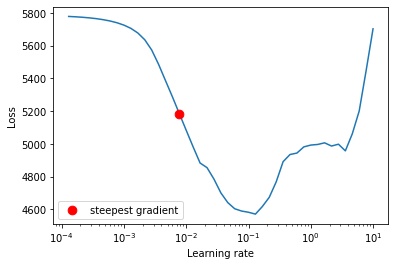

Begin LR Finder for model: bilstm+w2v
Learning rate search finished. See the graph with {finder_name}.plot()
Suggested LR: 7.74E-03


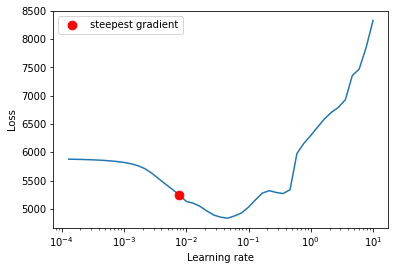

Begin LR Finder for model: bilstm+w2v+cnn
Learning rate search finished. See the graph with {finder_name}.plot()
Suggested LR: 5.61E-03


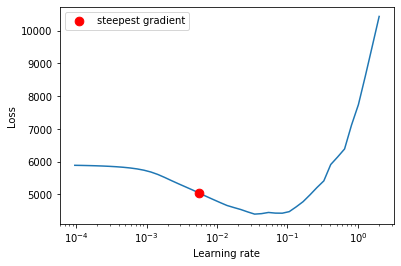

Begin LR Finder for model: bilstm+w2v+cnn+attn
Learning rate search finished. See the graph with {finder_name}.plot()
Suggested LR: 5.11E-03


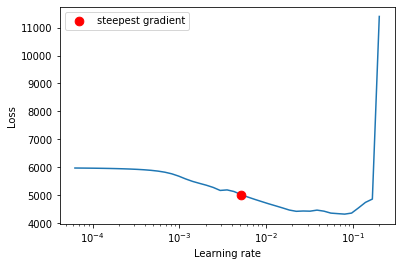

Begin LR Finder for model: transformer+w2v+cnn
Learning rate search finished. See the graph with {finder_name}.plot()
Suggested LR: 3.72E-05


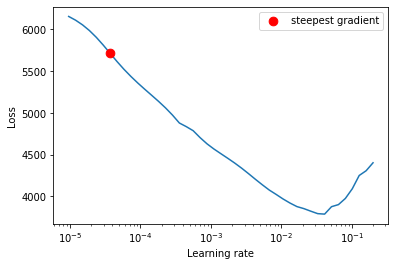

In [20]:
for model_name in configs:
    print(f"Begin LR Finder for model: {model_name}")
    model = NERModel(**configs[model_name])
    start_lr, end_lr = search_space[model_name]
    lr_finder = LRFinder(model, Adam(model.parameters(), lr=start_lr, weight_decay=1e-2), device=use_device)
    lr_finder.range_test(corpus.train_iter, corpus.val_iter, end_lr=end_lr, num_iter=55, step_mode="exp", diverge_th=3, disable_progress_bar=True,model_name=model_name)
    data_table_lr = wandb.Table(dataframe=lr_finder.data_table)
    wandb.log({f"key_table_lr_{model_name}":data_table_lr})
    lr_finder.plot(skip_start=10, skip_end=0, suggest_lr=True,model_name=model_name)
    data_table_lr_suggest = wandb.Table(dataframe=lr_finder.data_table_img)
    wandb.log({f"key_table_lr_suggest_{model_name}":data_table_lr_suggest})
    lr_finder.reset()

### Model Experiments

In [21]:
# New initial learning rate
lrs = {
    "bilstm": 7.74e-03,
    "bilstm+w2v": 7.74e-03,
    "bilstm+w2v+cnn": 5.61e-03,
    "bilstm+w2v+cnn+attn": 5.11e-03,
    "transformer+w2v+cnn": 3.72e-05
}
max_epochs = 50
no_improvement = 10
histories = {}
df_train_metrics = None
df_test_metrics = None

In [22]:
for model_name in configs:
    print(f"Start Training: {model_name}")
    model = NERModel(**configs[model_name])
    wandb.watch(model,log="all")
    
    trainer = Trainer(
        model=model,
        data=corpus,
        optimizer=Adam(model.parameters(), lr=lrs[model_name], weight_decay=1e-2),  # add weight decay for Adam
        device=use_device,
        checkpoint_path=f"{DRIVE_ROOT}/models-wandb-7030-v2/{model_name}.pt",
        model_name=f"{model_name}"
    )
    
    histories[model_name], df_train_metrics, df_test_metrics = trainer.train(max_epochs, no_improvement)
    data_table_train = wandb.Table(dataframe=df_train_metrics)
    wandb.log({f"key_table_train_val_metrics_{model_name}":data_table_train})
    data_table_test = wandb.Table(dataframe=df_test_metrics)
    wandb.log({f"key_table_test_metrics_{model_name}":data_table_test})
    print(f"Done Training: {model_name}")
    print(f"Model Information:")
    print(model)

Start Training: bilstm
Epoch     1: found better Val F1: 0.5077 (Train F1: 0.4606), saving model...
Epoch     2: found better Val F1: 0.6720 (Train F1: 0.6381), saving model...
Epoch     4: found better Val F1: 0.7008 (Train F1: 0.6813), saving model...
Epoch    14: found better Val F1: 0.7122 (Train F1: 0.7146), saving model...
Epoch    15: found better Val F1: 0.7203 (Train F1: 0.7106), saving model...
Epoch    19: reducing learning rate of group 0 to 2.3220e-03.
Epoch    20: found better Val F1: 0.7351 (Train F1: 0.7707), saving model...
Epoch    22: found better Val F1: 0.7457 (Train F1: 0.7969), saving model...
Epoch    26: reducing learning rate of group 0 to 6.9660e-04.
Epoch    27: found better Val F1: 0.7632 (Train F1: 0.8598), saving model...
Epoch    31: reducing learning rate of group 0 to 2.0898e-04.
Epoch    35: reducing learning rate of group 0 to 6.2694e-05.
No improvement after 10 epochs, stop training.
Done Training: bilstm
Model Information:
NERModel(
  (embeddings):

### Model Information

In [23]:
columns_info=["model","num_params","training_time"]
data_model_info = wandb.Table(columns=columns_info)

In [24]:
max_len_model_name = max([len(m) for m in histories])
print(f"{'MODEL NAME'.ljust(max_len_model_name)}\t{'NUM PARAMS'.ljust(10)}\tTRAINING TIME")
for model_name, history in histories.items():
    print(f"{model_name.ljust(max_len_model_name)}\t{history['num_params']:,}\t{int(history['elapsed_train_time']//60)}m {int(history['elapsed_train_time'] % 60)}s")
    data_model_info.add_data(model_name,history['num_params'],f"{int(history['elapsed_train_time']//60)}m {int(history['elapsed_train_time'] % 60)}s")
    wandb.log({"key_table_model_info":data_model_info})

MODEL NAME         	NUM PARAMS	TRAINING TIME
bilstm             	9,307,936	65m 40s
bilstm+w2v         	9,307,936	55m 2s
bilstm+w2v+cnn     	9,388,041	71m 2s
bilstm+w2v+cnn+attn	9,454,089	41m 57s
transformer+w2v+cnn	14,433,545	72m 38s


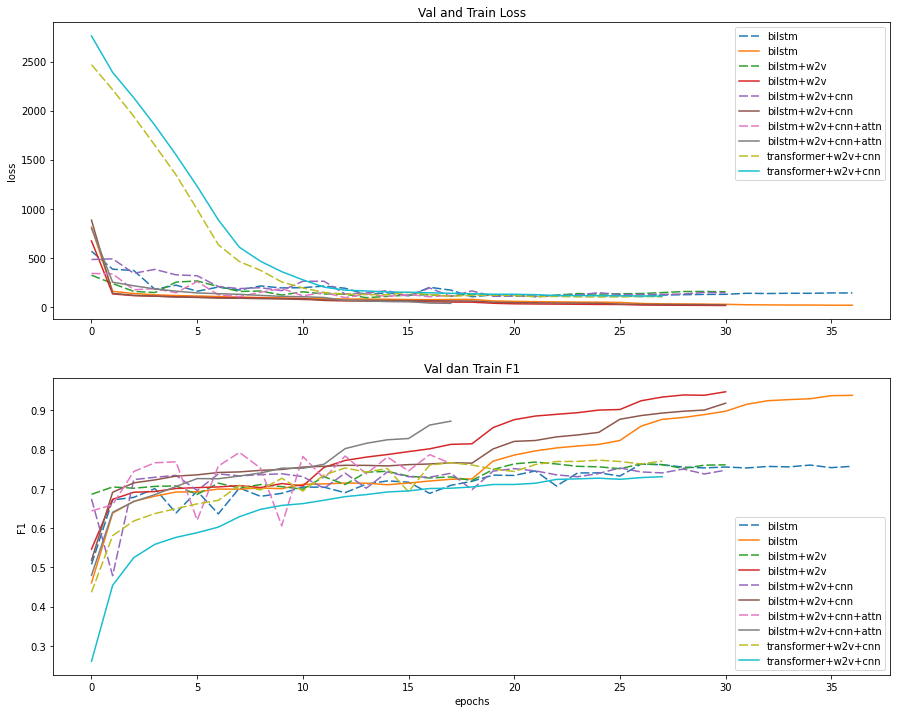

In [25]:
model_name = "bilstm"
val_loss1 = histories[model_name]["val_loss"]
val_loss2 = histories["bilstm+w2v"]["val_loss"]
fig, axs = plt.subplots(2, 1, figsize=(15, 12))
for model_name in histories:
    axs[0].plot(histories[model_name]["val_loss"], dashes=[6, 2], label=model_name)
    axs[0].plot(histories[model_name]["train_loss"], label=model_name)
    axs[1].plot(histories[model_name]["val_f1"], dashes=[6, 2], label=model_name)
    axs[1].plot(histories[model_name]["train_f1"], label=model_name)
_ = axs[0].set_title("Val and Train Loss")
_ = axs[1].set_title("Val dan Train F1")
_ = axs[1].set_xlabel("epochs")
_ = axs[0].set_ylabel("loss")
_ = axs[1].set_ylabel("F1")
_ = axs[0].legend(loc="upper right")
_ = axs[1].legend(loc="lower right")

wandb.log({"train_val_loss_f1_chart":wandb.Image(fig)})

[0.7653595371475802, 0.7671083185357191, 0.7674823199801171, 0.7763236422542416, 0.801447867926194]


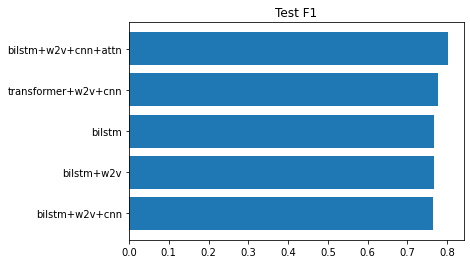

In [26]:
model_test_f1 = [(m, histories[m]["test_f1"]) for m in histories]
model_test_f1_sorted = sorted(model_test_f1, key=lambda m: m[1])
model_names = [m[0] for m in model_test_f1_sorted]
y_pos = list(range(len(model_names)))
f1_scores = [m[1] for m in model_test_f1_sorted]
flatten_f1 =  [element for sublist in f1_scores for element in sublist]
print(str(flatten_f1))

fig, ax = plt.subplots()
_ = ax.barh(y_pos, flatten_f1, align='center')
_ = ax.set_yticks(y_pos)
_ = ax.set_yticklabels(model_names)
_ = ax.set_title("Test F1")

wandb.log({"test_f1_chart":wandb.Image(fig)})

### Model Testing

In [27]:
from ast import literal_eval
from tqdm import tqdm

In [28]:
data_test = pd.read_csv("/home/jupyter-pfsa-id/corpus/data_paragraph.csv",converters={'tags': literal_eval})

In [29]:
data_test.shape

(144, 5)

In [30]:
for model_name in configs:
    print(f"Sample inferences for model: {model_name}")

    model = NERModel(**configs[model_name]).to(use_device)
    tester = Trainer(
        model=model,
        data=corpus,
        optimizer=Adam(model.parameters(), lr=lrs[model_name], weight_decay=1e-2),  # add weight decay for Adam
        device=use_device,
        checkpoint_path=f"{DRIVE_ROOT}/models-wandb-7030-v2/{model_name}.pt",
        model_name=f"{model_name}"
    )
    tester.model.load_state(f"{DRIVE_ROOT}/models-wandb-7030-v2/{model_name}.pt")

    for index, row in tqdm(data_test.iterrows(),total=data_test.shape[0]):
        words, infer_tags, unknown_tokens = tester.infer(docs=row["paragraph"], index=index, true_tags=row["tags"])
    
    print()


Sample inferences for model: bilstm


  0%|          | 0/144 [00:00<?, ?it/s]


Sample inferences for model: bilstm+w2v


  0%|          | 0/144 [00:00<?, ?it/s]


Sample inferences for model: bilstm+w2v+cnn


  0%|          | 0/144 [00:00<?, ?it/s]


Sample inferences for model: bilstm+w2v+cnn+attn


  0%|          | 0/144 [00:00<?, ?it/s]


Sample inferences for model: transformer+w2v+cnn


100%|██████████| 144/144 [45:40<00:00, 19.03s/it]

In [31]:
print(torch.__version__)

1.5.1


In [32]:
wandb.finish()